**Author:** Raoul Malm  

**Description:** 

This notebook demonstrates the future price prediction for different stocks using recurrent neural networks in tensorflow. Recurrent neural networks with basic, LSTM or GRU cells are implemented. 

**Outline:**

1. [Libraries and settings](#1-bullet)
2. [Analyze data](#2-bullet)
3. [Manipulate data](#3-bullet)
4. [Model and validate data](#4-bullet)
5. [Predictions](#5-bullet)

**Reference:**  

[LSTM_Stock_prediction-20170507 by BenF](https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507/notebook)

# 1. Libraries and settings <a class="anchor" id="1-bullet"></a> 

In [2]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 


/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/Users/zen/opt/anaconda3/envs/envloop/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/Users/zen/opt/anaconda3/envs/envloop

# 2. Analyze data <a class="anchor" id="2-bullet"></a> 
- load stock prices from prices-split-adjusted.csv
- analyze data

In [3]:
df = pd.read_parquet('LTC-USDT.parquet')

df.drop(['volume', 'quote_asset_volume', 'number_of_trades', 'taker_buy_base_asset_volume', 'taker_buy_quote_asset_volume'],1,inplace=True)
df.info()
df.head()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1595426 entries, 2017-12-13 03:32:00 to 2020-12-29 23:59:00
Data columns (total 4 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   open    1595426 non-null  float32
 1   high    1595426 non-null  float32
 2   low     1595426 non-null  float32
 3   close   1595426 non-null  float32
dtypes: float32(4)
memory usage: 36.5 MB


,open,high,low,close
open_time,,,,
2017-12-13 03:32:00,272.0,272.0,272.0,272.0
2017-12-13 03:33:00,272.0,272.0,272.0,272.0
2017-12-13 03:34:00,272.0,272.0,272.0,272.0
2017-12-13 03:35:00,272.0,272.0,272.0,272.0
2017-12-13 03:36:00,272.0,272.0,272.0,272.0


In [4]:
df.tail()

,open,high,low,close
open_time,,,,
2020-12-29 23:55:00,129.380005,129.429993,129.270004,129.350006
2020-12-29 23:56:00,129.330002,129.350006,129.210007,129.250000
2020-12-29 23:57:00,129.240005,129.270004,128.919998,128.979996
2020-12-29 23:58:00,128.979996,128.990005,128.389999,128.570007
2020-12-29 23:59:00,128.580002,128.880005,128.500000,128.800003


In [5]:
df.describe()

,open,high,low,close
count,1.595426e+06,1.595426e+06,1.595426e+06,1.595426e+06
mean,8.002139e+01,8.010421e+01,7.993732e+01,8.002065e+01
std,5.168631e+01,5.178458e+01,5.158965e+01,5.168502e+01
min,2.239000e+01,2.244000e+01,2.232000e+01,2.238000e+01
25%,4.649000e+01,4.651000e+01,4.646000e+01,4.649000e+01
50%,5.962000e+01,5.967000e+01,5.958000e+01,5.962000e+01
75%,9.100000e+01,9.109000e+01,9.090000e+01,9.100000e+01
max,3.662500e+02,3.669600e+02,3.659900e+02,3.660000e+02


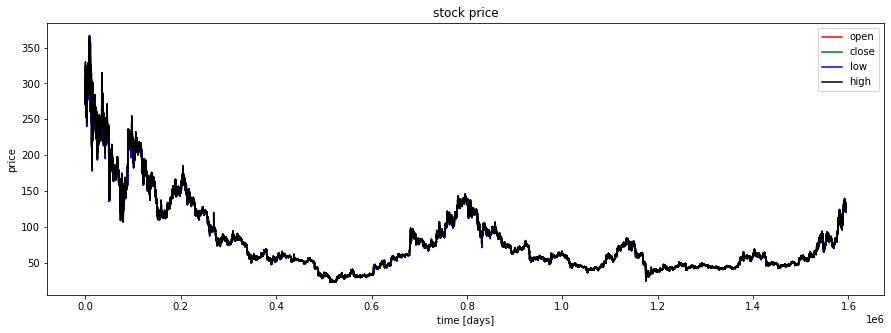

In [6]:
plt.figure(figsize=(15, 5));
plt.plot(df.open.values, color='red', label='open')
plt.plot(df.close.values, color='green', label='close')
plt.plot(df.low.values, color='blue', label='low')
plt.plot(df.high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
plt.show()


# 3. Manipulate data <a class="anchor" id="3-bullet"></a> 
- choose a specific stock
- drop feature: volume
- normalize stock data
- create train, validation and test data sets

In [7]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    opens = df.open.values.reshape(-1,1)
    lows = df.low.values.reshape(-1,1)
    highs = df.high.values.reshape(-1,1)
    closes = df['close'].values.reshape(-1,1)
    scale = min_max_scaler.fit(opens + highs + lows + closes)
    df['open'] = scale.transform(opens)
    df['high'] = scale.transform(highs)
    df['low'] = scale.transform(lows)
    df['close'] = scale.transform(closes)
    return df

# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len): 
        data.append(data_raw[index: index + seq_len])
    
    data = np.array(data);
    valid_set_size = int(np.round(valid_set_size_percentage/100*data.shape[0]));  
    test_set_size = int(np.round(test_set_size_percentage/100*data.shape[0]));
    train_set_size = data.shape[0] - (valid_set_size + test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_valid = data[train_set_size:train_set_size+valid_set_size,:-1,:]
    y_valid = data[train_set_size:train_set_size+valid_set_size,-1,:]
    
    x_test = data[train_set_size+valid_set_size:,:-1,:]
    y_test = data[train_set_size+valid_set_size:,-1,:]
    
    return [x_train, y_train, x_valid, y_valid, x_test, y_test]

# normalize stock
df_stock_norm = df.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)


x_train.shape =  (1276324, 19, 4)
y_train.shape =  (1276324, 4)
x_valid.shape =  (159541, 19, 4)
y_valid.shape =  (159541, 4)
x_test.shape =  (159541, 19, 4)
y_test.shape =  (159541, 4)


In [8]:
df_stock_norm

,open,high,low,close
open_time,,,,
2017-12-13 03:32:00,0.132678,0.132678,0.132678,0.132678
2017-12-13 03:33:00,0.132678,0.132678,0.132678,0.132678
2017-12-13 03:34:00,0.132678,0.132678,0.132678,0.132678
2017-12-13 03:35:00,0.132678,0.132678,0.132678,0.132678
2017-12-13 03:36:00,0.132678,0.132678,0.132678,0.132678
...,...,...,...,...
2020-12-29 23:55:00,0.028947,0.028984,0.028867,0.028926
2020-12-29 23:56:00,0.028911,0.028926,0.028824,0.028853
2020-12-29 23:57:00,0.028846,0.028867,0.028613,0.028656


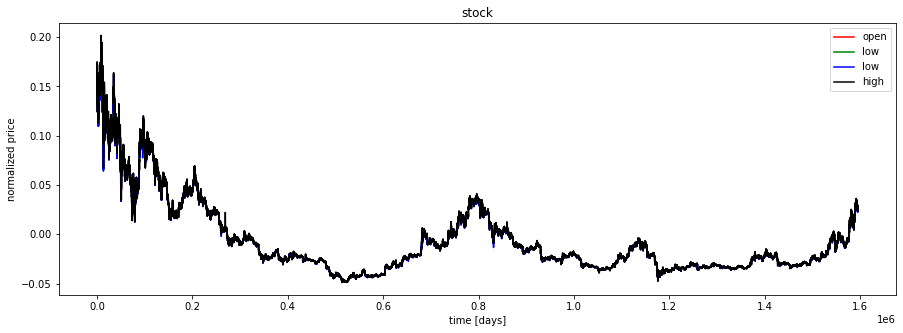

In [9]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best')
plt.show()

# 4. Model and validate data <a class="anchor" id="4-bullet"></a> 
- RNNs with basic, LSTM, GRU cells


In [10]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4
n_neurons = 1 # 200
n_outputs = 4
n_layers = 1 # 2
learning_rate = 0.001
batch_size = 50
n_epochs = 1 # 100
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.compat.v1.disable_eager_execution()
tf.compat.v1.reset_default_graph()

X = tf.compat.v1.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.compat.v1.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.compat.v1.nn.rnn_cell.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.compat.v1.nn.rnn_cell.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.compat.v1.nn.rnn_cell.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.compat.v1.nn.rnn_cell.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]

Instructions for updating:
This class is equivalent as tf.keras.layers.SimpleRNNCell, and will be replaced by that in Tensorflow 2.0.


In [11]:
multi_layer_cell = tf.compat.v1.nn.rnn_cell.MultiRNNCell(layers)
rnn_outputs, states = tf.compat.v1.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.compat.v1.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)

Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dense instead.


In [12]:
y_train.shape

(1276324, 4)

In [13]:
# run graph
with tf.compat.v1.Session() as sess: 
    sess.run(tf.compat.v1.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

0.00 epochs: MSE train/valid = 0.002770/0.001704


In [14]:
y_test

array([[-0.03014743, -0.03010379, -0.03016197, -0.03014015],
       [-0.03014743, -0.03013288, -0.0301547 , -0.0301547 ],
       [-0.0301547 , -0.03014015, -0.03016197, -0.0301547 ],
       ...,
       [ 0.02891099,  0.02892554,  0.02882371,  0.0288528 ],
       [ 0.02884553,  0.02886735,  0.02861279,  0.02865642],
       [ 0.02865642,  0.0286637 ,  0.0282273 ,  0.02835823]],
      dtype=float32)

In [15]:
y_test_pred

array([[-0.03003804, -0.02999313, -0.0300777 , -0.03004909],
       [-0.03004169, -0.0299968 , -0.03008135, -0.03005274],
       [-0.03004789, -0.030003  , -0.03008753, -0.03005895],
       ...,
       [ 0.02886359,  0.0290083 ,  0.02874054,  0.02886604],
       [ 0.02883582,  0.02898048,  0.02871279,  0.02883825],
       [ 0.02869108,  0.02883551,  0.02856827,  0.0286935 ]],
      dtype=float32)

In [16]:
outputs

<tf.Tensor 'strided_slice:0' shape=(?, 4) dtype=float32>

In [17]:
sess.run(outputs, feed_dict={X: x_test})

RuntimeError: Attempted to use a closed Session.

In [ ]:
sess

# 5. Predictions <a class="anchor" id="5-bullet"></a> 

In [ ]:
y_train.shape

In [ ]:
ft = 0 # 0 = open, 1 = close, 2 = highest, 3 = lowest

## show predictions
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);

plt.plot(np.arange(y_train.shape[0]), y_train[:,ft], color='blue', label='train target')

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_valid.shape[0]), y_valid[:,ft],
         color='gray', label='valid target')

plt.plot(np.arange(y_train.shape[0]+y_valid.shape[0],
                   y_train.shape[0]+y_test.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0]),y_train_pred[:,ft], color='red',
         label='train prediction')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_valid_pred.shape[0]),
         y_valid_pred[:,ft], color='orange', label='valid prediction')

plt.plot(np.arange(y_train_pred.shape[0]+y_valid_pred.shape[0],
                   y_train_pred.shape[0]+y_valid_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('past and future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

plt.subplot(1,2,2);

plt.plot(np.arange(y_train.shape[0], y_train.shape[0]+y_test.shape[0]),
         y_test[:,ft], color='black', label='test target')

plt.plot(np.arange(y_train_pred.shape[0], y_train_pred.shape[0]+y_test_pred.shape[0]),
         y_test_pred[:,ft], color='green', label='test prediction')

plt.title('future stock prices')
plt.xlabel('time [days]')
plt.ylabel('normalized price')
plt.legend(loc='best');

corr_price_development_train = np.sum(np.equal(np.sign(y_train[:,1]-y_train[:,0]),
            np.sign(y_train_pred[:,1]-y_train_pred[:,0])).astype(int)) / y_train.shape[0]
corr_price_development_valid = np.sum(np.equal(np.sign(y_valid[:,1]-y_valid[:,0]),
            np.sign(y_valid_pred[:,1]-y_valid_pred[:,0])).astype(int)) / y_valid.shape[0]
corr_price_development_test = np.sum(np.equal(np.sign(y_test[:,1]-y_test[:,0]),
            np.sign(y_test_pred[:,1]-y_test_pred[:,0])).astype(int)) / y_test.shape[0]

print('correct sign prediction for close - open price for train/valid/test: %.2f/%.2f/%.2f'%(
    corr_price_development_train, corr_price_development_valid, corr_price_development_test))
